In [1]:
# Car Model Prediction

In [1]:
from src.SVM import SVM
from src.Softmax import Softmax
from src.vector_generator import CarPredictor
from src.utils import show_images, get_acc
from src.reader import TrainSet, TestSet

import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'\n{device} will be used as device')
print(torch.cuda.get_device_name(0))


cuda:0 will be used as device
NVIDIA GeForce RTX 2070 with Max-Q Design


In [2]:
# Load and display images

root = 'data/data'
scale_size = 224
batch_size = 128

transform = transforms.Compose([
   transforms.Resize((scale_size, scale_size)),
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225],
                        inplace=True)
])

train_data = TrainSet(root=root, device=device, transform=transform)
test_data = TestSet(root=root, device=device, transform=transform)

In [3]:
# Retrieve test and train dataframes
# Warning: Very time consuming

griddim = 1, 2
blockdim = 3, 4

cp = CarPredictor(device)
train_df = cp.get_train_df(train_data)
test_df = cp.get_test_df(test_data)

d:\source\repos\car_prediction\src\vector_generator.py:25: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "get_train_ds" failed type inference due to: non-precise type pyobject
During: typing of argument at d:\source\repos\car_prediction\src\vector_generator.py (27)

File "src\vector_generator.py", line 27:
    def get_train_ds(self, dataset: TrainSet):
        vectors = []
        ^

  @jit()
d:\source\repos\car_prediction\src\vector_generator.py:25: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "get_train_ds" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "src\vector_generator.py", line 31:
    def get_train_ds(self, dataset: TrainSet):
        <source elided>

        for i in range(len(dataset)):
        ^

  @jit()
C:\Users\okori\AppData\Roaming\Python\Python39\site-packages\numba\core\object_mode_passes.py:151

KeyboardInterrupt: 

In [3]:
# save cleaned up data to disk
import numpy as np
np.save('research_data_train', train_df)
np.save('research_data_train_labels', train_df.columns)
np.save('research_data_test', test_df) 
np.save('research_data_test_labels', test_df.columns)

In [4]:
# Split out validation set
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# load from disk
train_df = pd.DataFrame(
    data=np.load('research_data_train.npy', allow_pickle=True),
    columns=np.load('research_data_train_labels.npy', allow_pickle=True))

test_df = pd.DataFrame(
    data=np.load('research_data_test.npy', allow_pickle=True),
    columns=np.load('research_data_test_labels.npy', allow_pickle=True))

y_train = train_df['Match'].astype(int)
x_train = train_df.drop('Match', axis=1).drop('label1', axis=1).drop('label2', axis=1).drop('path1', axis=1).drop('path2', axis=1)
xTrain, xVal, yTrain, yVal = train_test_split(x_train, y_train, test_size=0.20, random_state=42)

xTrainPath = xTrain['Path'].to_numpy()
xValPath = xVal['Path'].to_numpy()

xTrain = xTrain.drop('Path', axis=1).to_numpy()
xVal = xVal.drop('Path', axis=1).to_numpy()

yTrain = yTrain.to_numpy()
yVal = yVal.to_numpy()

x_test_path = test_df['Path'].to_numpy()
y_test = test_df['Match'].astype(int).to_numpy()
x_test = test_df.drop('Match', axis=1).drop('Path', axis=1).astype(float).to_numpy()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

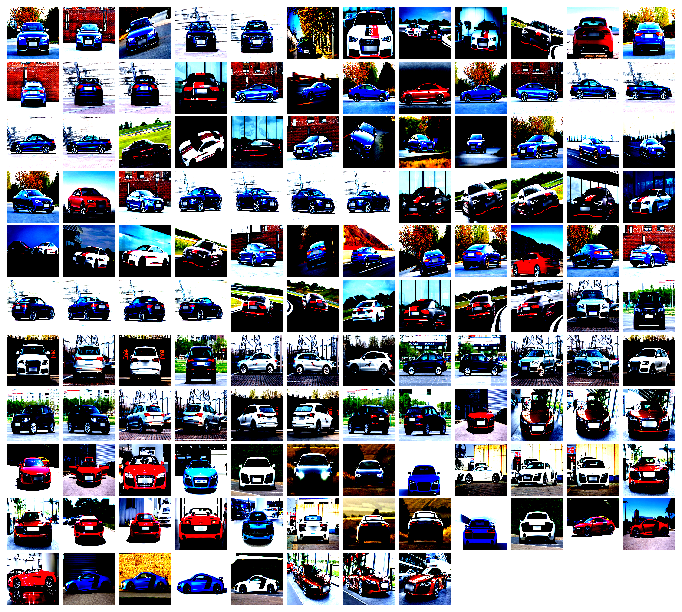

In [7]:
# Visualize some images

imgs = []
for i in range(batch_size):
    imgs.append(train_data[i][1].numpy())

show_images(np.array(imgs), color=True)

In [13]:
learning_rate = 0.1
epochs = 500
n_class = 2
rc = 0.001

svm_model = SVM(n_class, learning_rate, epochs, rc).to(device)

# train
svm_losses = svm_model(xTrain, yTrain)

predTrain = svm_model.predict(xTrain)
accTrain = get_acc(predTrain, yTrain)

# validate
predValidation = svm_model.predict(xVal)
accValidation = get_acc(predValidation, yVal)

print('SVM Training Accuracy : %f | Validation Accuracy: %f' % (accTrain, accValidation))

SVM Training Accuracy : 65.695640 | Validation Accuracy: 65.422763


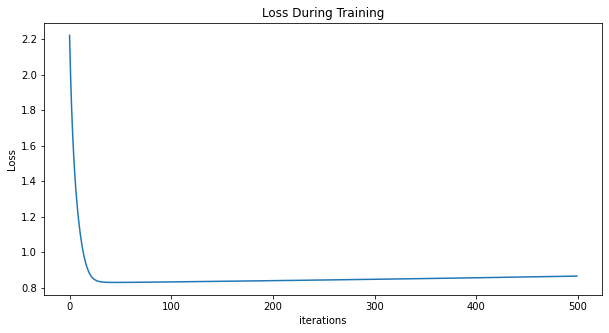

In [14]:
# plot error

plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(svm_losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

In [15]:
predTest = svm_model.predict(x_test)
accTest = get_acc(predTest, y_test)

print('SVM Test Accuracy: %f' % (accTest))

SVM Test Accuracy: 47.865000


In [4]:
# Softmax

In [8]:
learning_rate = 0.1
epochs = 100
n_class = 2
rc = 0.01

sx_model = Softmax(n_class, learning_rate, epochs, rc).to(device)

# train
sx_losses = sx_model(xTrain, yTrain)

predTrain_sx = sx_model.predict(xTrain)
accTrain_sx = get_acc(predTrain_sx, yTrain)

# validate
predValidation_sx = sx_model.predict(xVal)
accValidation_sx = get_acc(predValidation_sx, yVal)

print('Sotfmax Training Accuracy : %f | Validation Accuracy: %f' % (accTrain_sx, accValidation_sx))

Sotfmax Training Accuracy : 65.279823 | Validation Accuracy: 65.019907


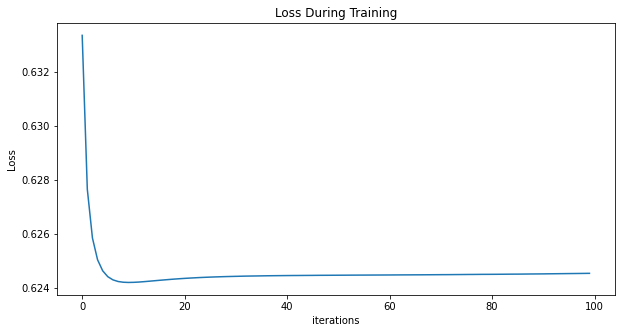

In [10]:
# plot error
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(sx_losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

In [11]:
predTest_sx = sx_model.predict(x_test)
accTest_sx = get_acc(predTest_sx, y_test)

print('Softmax Test Accuracy: %f' % (accTest_sx))

# for i in range(batch_size):


Softmax Test Accuracy: 47.965000


In [9]:
all_zeros = train_df[train_df['Match'] == 0]
all_ones = train_df[train_df['Match'] == 1]
print(train_df['Match'].head())
print(train_df.shape)
print('1s', all_ones.shape)
print('0s', all_zeros.shape)
print(y_train.head())

0    1.0
1    1.0
2    1.0
3    0.0
4    0.0
Name: Match, dtype: float64
(212233, 203)
1s (106686, 203)
0s (105547, 203)
0    1
1    1
2    1
3    0
4    0
Name: Match, dtype: int32


In [12]:
all_zeros = test_df[test_df['Match'] == '0']
all_ones = test_df[test_df['Match'] == '1']
print(test_df.shape)
print('1s', all_ones.shape)
print('0s', all_zeros.shape)

(20000, 201)
1s (10000, 201)
0s (10000, 201)


In [13]:
print('xTrain', xTrain.shape)
print('x_test', x_test.shape)
print('yTrain', yTrain.shape)
print('y_text', y_test.shape)
print(type(x_test[0][0]))

xTrain (1780, 200)
x_test (20000, 200)
yTrain (1780,)
y_text (20000,)
<class 'numpy.float64'>


SVM Training Accuracy : 62.590909 | Validation Accuracy: 60.000000


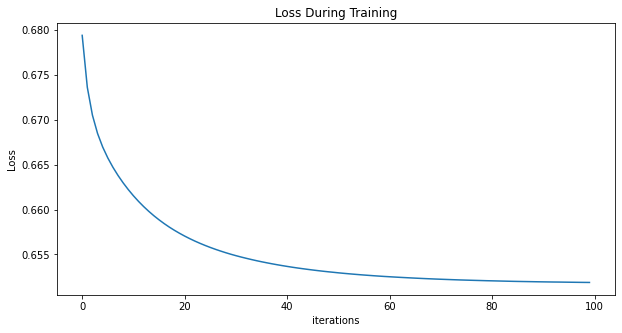

In [10]:
test_df = pd.DataFrame(
    data=np.load('research_data_test.npy', allow_pickle=True),
    columns=np.load('research_data_test_labels.npy', allow_pickle=True))

y_test = test_df['Match'].astype(int)
x_test = test_df.drop('Match', axis=1).astype(float)

xTrain, xVal, yTrain, yVal = train_test_split(x_test, y_test, test_size=0.01, random_state=42)

xTrain = xTrain.to_numpy()
xVal = xVal.to_numpy()
yTrain = yTrain.to_numpy()
yVal = yVal.to_numpy()

learning_rate = 0.01
epochs = 100
n_class = 2
rc = 0.001

svm_model = Softmax(n_class, learning_rate, epochs, rc).to(device)

# print(x_test[0])
# print(y_test[0])

# train
svm_losses = svm_model(xTrain, yTrain)

predTrain = svm_model.predict(xTrain)
accTrain = get_acc(predTrain, yTrain)

# validate
predValidation = svm_model.predict(xVal)
accValidation = get_acc(predValidation, yVal)

print('SVM Training Accuracy : %f | Validation Accuracy: %f' % (accTrain, accValidation))

plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(svm_losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()